In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
data = {
    'index' : [
        pd.to_datetime('1989-12-31'),
        pd.to_datetime('1990-12-31'),
        pd.to_datetime('1991-12-31'),
        pd.to_datetime('1992-12-31'),
        pd.to_datetime('1993-12-31'),
        pd.to_datetime('1994-12-31'),
        pd.to_datetime('1995-12-31'),
        pd.to_datetime('1996-12-31'),
        pd.to_datetime('1997-12-31'),
        pd.to_datetime('1998-12-31'),
        pd.to_datetime('1999-12-31'),
        pd.to_datetime('2000-12-31'),
        pd.to_datetime('2001-12-31'),
        pd.to_datetime('2002-12-31'),
        pd.to_datetime('2003-12-31'),
        pd.to_datetime('2004-12-31'),
        pd.to_datetime('2005-12-31'),
        pd.to_datetime('2006-12-31'),
        pd.to_datetime('2007-12-31'),
        pd.to_datetime('2008-12-31'),
        pd.to_datetime('2009-12-31'),
        pd.to_datetime('2010-12-31'),
        pd.to_datetime('2011-12-31'),
        pd.to_datetime('2012-12-31'),
        pd.to_datetime('2013-12-31'),
        pd.to_datetime('2014-12-31'),
        pd.to_datetime('2015-12-31'),
        pd.to_datetime('2016-12-31'),
        pd.to_datetime('2017-12-31'),
        pd.to_datetime('2019-12-31'),
        pd.to_datetime('2029-12-31'),
        pd.to_datetime('2039-12-31'),
        pd.to_datetime('2049-12-31')
    ],
    'data' : [
        1251.0,
        1203.9,
        1153.8,
        1144.9,
        1125.8,
        1123.0,
        1141.1,
        1106.0,
        1080.7,
        1047.0,
        1045.2,
        1060.3,
        1038.9,
        1035.6,
        1019.1,
        993.3,
        1000.6,
        973.9,
        975.6,
        908.1,
        942.5,
        920.3,
        924.6,
        942.3,
        903.2,
        907.2,
        911.0,
        906.6,
        865.6,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
    ],
    'target' : [
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        907.2,
        np.nan,
        np.nan,
        np.nan,
        750.6,
        562.9,
        375.3,
        62.5,
    ],
    'prog' : [
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        907.2,
        np.nan,
        np.nan,
        np.nan,
        838.2,
        725.6,
        375.3,
        62.5,
    ],
    'wc' : [
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        907.2,
        np.nan,
        np.nan,
        np.nan,
        838.2,
        725.6,
        600.0,
        400.0,
    ],
}

In [22]:
df = pd.DataFrame(data)

In [23]:
df.set_index('index', inplace=True)
df.to_pickle('data/co2_ger_asof_1990_with_prog.pkl')
#df = read_pickle('data/co2_ger_asof_1990_with_prog.pkl')

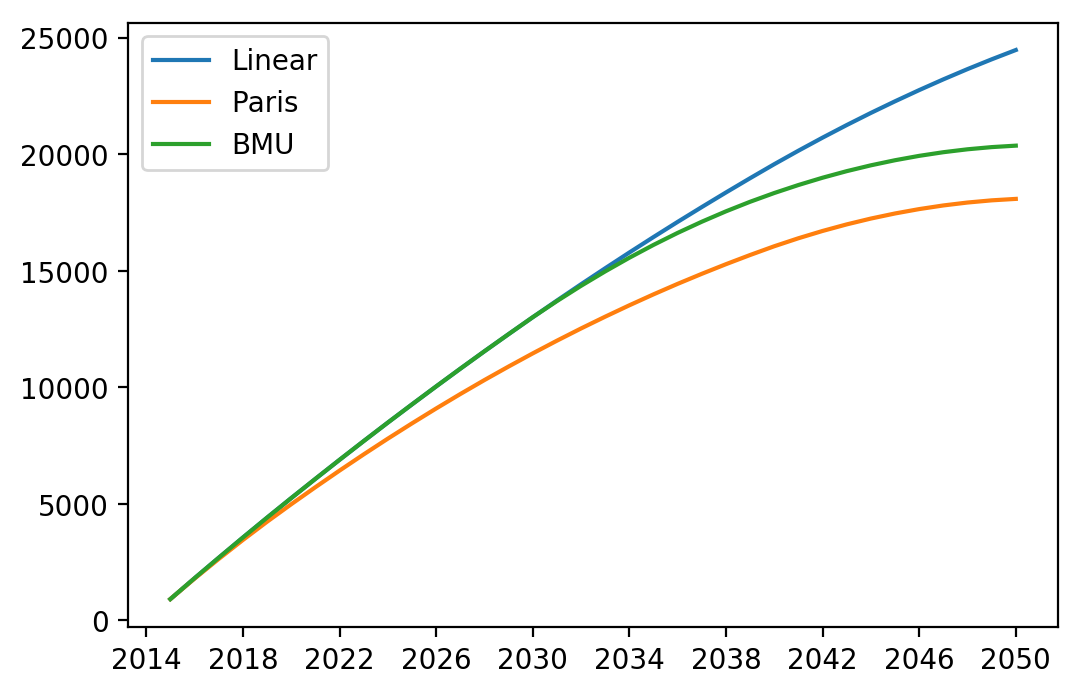

In [24]:
plt.figure(dpi=200)

plt.plot(df.resample('1Y').interpolate().cumsum()['wc'], label='Linear')
plt.plot(df.resample('1Y').interpolate().cumsum()['target'], label='Paris')
plt.plot(df.resample('1Y').interpolate().cumsum()['prog'], label='BMU')

plt.legend()

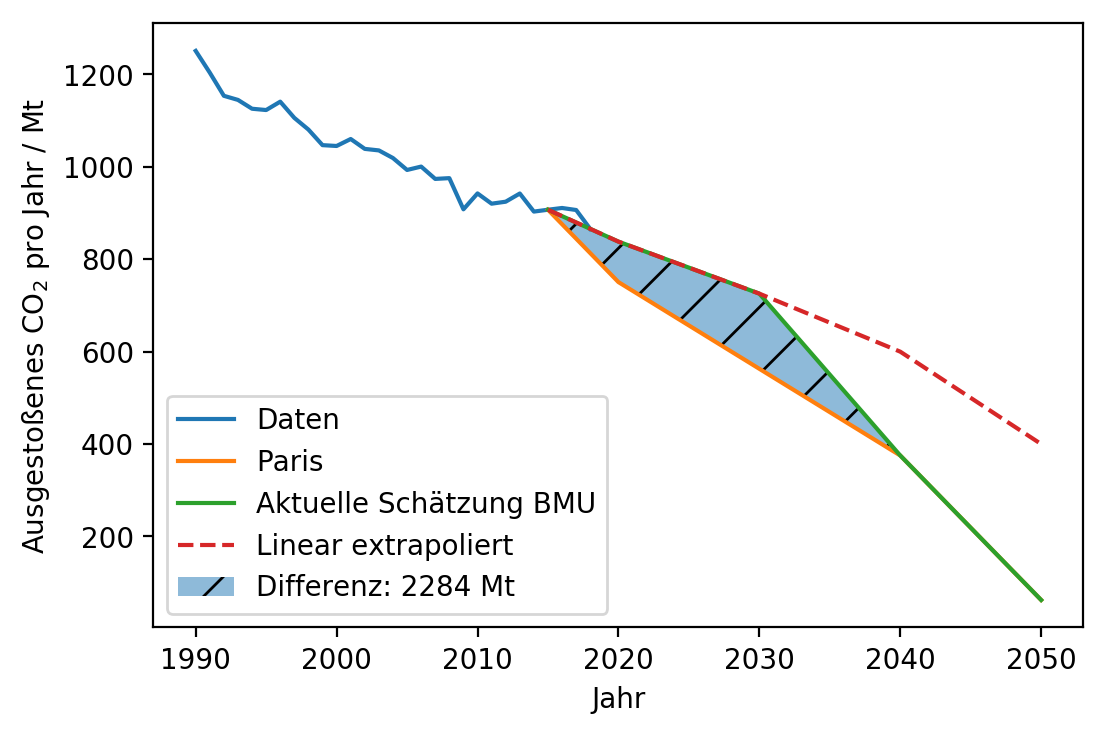

In [25]:
plt.figure(dpi=200)

plt.plot(df.resample('1Y').mean()['data'], label = 'Daten')
plt.plot(df.resample('1Y').interpolate()['target'], label = 'Paris')
plt.plot(df.resample('1Y').interpolate()['prog'], label = 'Aktuelle Schätzung BMU')


diff = (
    df.resample('1Y').interpolate()['prog']-df.resample('1Y').interpolate()['target']
).sum()

plt.fill_between(
    df.resample('1Y').interpolate()['target'].index,
    df.resample('1Y').interpolate()['target'],
    df.resample('1Y').interpolate()['prog'],
    label=f'Differenz: {diff:.0f} Mt', alpha=0.5, hatch='/'
)

plt.plot(df.resample('1Y').interpolate()['wc'], label = 'Linear extrapoliert', linestyle='--')

plt.xlabel('Jahr')
plt.ylabel('Ausgestoßenes CO$_2$ pro Jahr / Mt')

plt.legend()

## Paris Budget as of 2015:

In [28]:
budget = df.resample('1Y').interpolate()['target'].sum()

In [34]:
df_rest = budget - df.resample('1Y').interpolate()['2014':].fillna(0).cumsum()

Text(0.5,0,'Jahr')

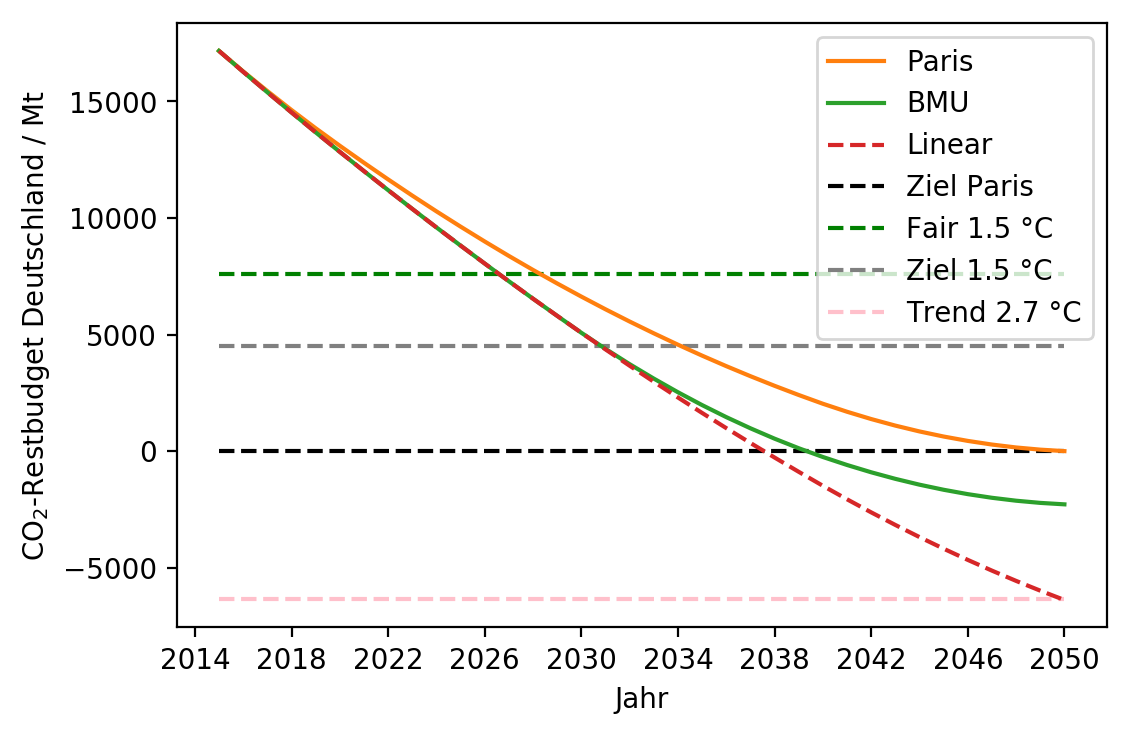

In [68]:
plt.figure(dpi=200)

plt.plot([df_rest.index.min(),df_rest.index.min()],[0,0])

plt.plot(df_rest['target'], label='Paris')
plt.plot(df_rest['prog'], label='BMU')
plt.plot(df_rest['wc'], label='Linear', linestyle='--')

plt.hlines(0, df_rest.index.min(), df_rest.index.max(), linestyle='--', label='Ziel Paris')
plt.hlines(budget-10500, df_rest.index.min(), df_rest.index.max(), linestyle='--', label='Fair 1.5 °C', color='green')
plt.hlines(4500, df_rest.index.min(), df_rest.index.max(), linestyle='--', label='Ziel 1.5 °C', color='grey')
plt.hlines(-6326, df_rest.index.min(), df_rest.index.max(), linestyle='--', label='Trend 2.7 °C', color='pink')

plt.legend()
plt.ylabel('CO$_2$-Restbudget Deutschland / Mt')
plt.xlabel('Jahr')

''

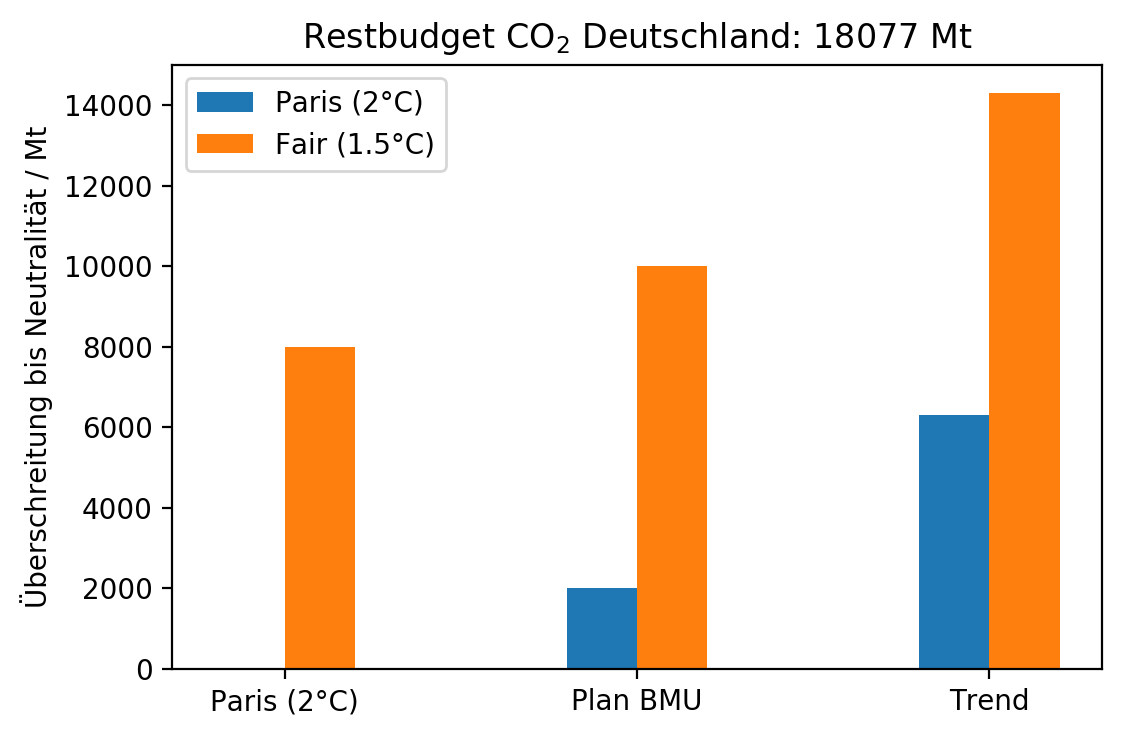

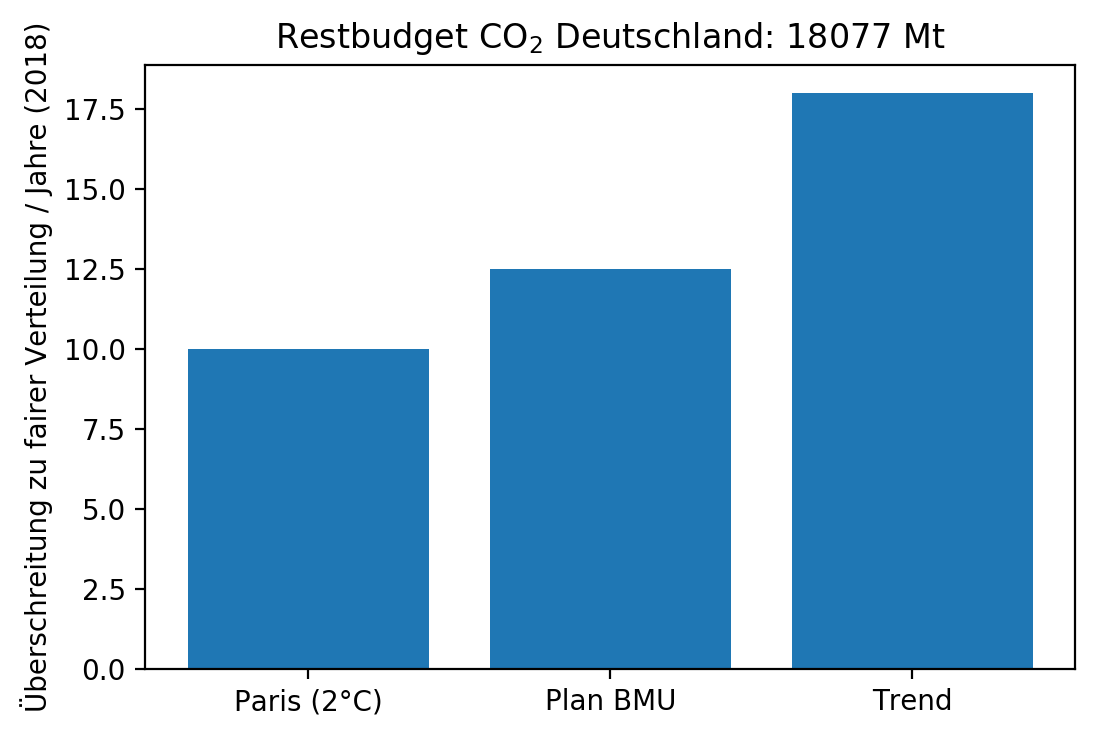

In [84]:
plt.figure(dpi=200)
plt.bar(np.arange(1,4)-0.1,[0,2000,6300], width=0.2, label='Paris (2°C)')

plt.title(f'Restbudget CO$_2$ Deutschland: {budget:.0f} Mt')
plt.ylabel('Überschreitung bis Neutralität / Mt')
;
plt.bar(np.arange(1,4)+0.1,[8000,10000,14300], width=0.2, label='Fair (1.5°C)')

plt.xticks(np.arange(1,4),['Paris (2°C)','Plan BMU','Trend'])
plt.legend()

;
plt.figure(dpi=200)
plt.bar(['Paris (2°C)','Plan BMU','Trend'],[10,12.5,18])

plt.title(f'Restbudget CO$_2$ Deutschland: {budget:.0f} Mt')
plt.ylabel('Überschreitung zu fairer Verteilung / Jahre (2018)')
;

In [63]:
budget / 2 * 2.7 - budget

6326.897500000003